In [1]:
# Libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import itertools

In [2]:
airports = pd.read_csv("../data/airports_cleaned.csv", keep_default_na=False)
airports

,airport_name,city,country,IATA,latitude,longitude,continent_code
0,Goroka Airport,Goroka,Papua New Guinea,GKA,-6.081690,145.391998,OC
1,Madang Airport,Madang,Papua New Guinea,MAG,-5.207080,145.789001,OC
2,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,-5.826790,144.296005,OC
3,Nadzab Airport,Nadzab,Papua New Guinea,LAE,-6.569803,146.725977,OC
4,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,-9.443380,147.220001,OC
...,...,...,...,...,...,...,...
5919,Bilogai-Sugapa Airport,Sugapa-Papua Island,Indonesia,UGU,-3.739560,137.031998,AS
5920,Ramon Airport,Eilat,Israel,ETM,29.723694,35.011416,AS
5921,Rustaq Airport,Al Masna'ah,Oman,MNH,23.640556,57.487500,AS
5922,Laguindingan Airport,Cagayan de Oro City,Philippines,CGY,8.612203,124.456496,AS


In [3]:
routes = pd.read_csv("../data/routes_cleaned.csv", keep_default_na=False)
routes

,source,destination,source_lat,source_lon,source_code,dest_lat,dest_lon,dest_code,distance
0,AER,KZN,43.449902,39.956600,EU,55.606201,49.278702,EU,1507.99
1,ASF,KZN,46.283298,48.006302,EU,55.606201,49.278702,EU,1040.94
2,CEK,KZN,55.305801,61.503300,EU,55.606201,49.278702,EU,773.13
3,DME,KZN,55.408798,37.906300,EU,55.606201,49.278702,EU,718.08
4,EGO,KZN,50.643799,36.590099,EU,55.606201,49.278702,EU,1010.82
...,...,...,...,...,...,...,...,...,...
36601,ZKE,YFA,52.282501,-81.677803,NA,52.201401,-81.696899,NA,9.12
36602,YPO,YAT,54.988098,-85.443298,NA,52.927502,-82.431900,NA,302.73
36603,ZKE,YAT,52.282501,-81.677803,NA,52.927502,-82.431900,NA,88.10
36604,JCK,RCM,-20.668301,141.723007,OC,-20.701900,143.115005,OC,145.08


In [4]:
G = nx.from_pandas_edgelist(routes,"source","destination",edge_attr="distance",create_using=nx.DiGraph())
nx.set_node_attributes(G,airports.continent_code.copy().rename(airports.IATA).to_dict(),'continent_code')
nx.set_node_attributes(G,airports.latitude.copy().rename(airports.IATA).to_dict(),'latitude')
nx.set_node_attributes(G,airports.longitude.copy().rename(airports.IATA).to_dict(),'longitude')

In [5]:
def find_route(G,start_airport,must_go=[]):

    start = start_airport
    sites = []
    continents = ["NA", "SA", "EU", "AF", "AS", "OC"]

    # Removing from the list of continents the continent of the initial airport
    start_continent = G.nodes[start]['continent_code']
    continents.remove(start_continent)

    # Removing from the list of continents the continents of the "must_go" airports
    for i in range(len(must_go)):
        must_go_continent = G.nodes[must_go[i]]['continent_code']
        if must_go_continent in continents:
            continents.remove(must_go_continent)
    
    while (len(continents)+len(must_go) > 0):
        # Taking only the airports that are in the continents that the route has not yet passed
        pos_airports = [x for x,y in G.nodes(data=True) if (y['continent_code'] in continents)]
        # Adding airports of the "must_go" list
        pos_airports = pos_airports + must_go
        # Getting the distances to the nearest airports
        pos_dest = nx.single_source_dijkstra(G,start,weight='distance')[0]
        # Removing the first airport (same airport)
        del pos_dest[start]
        # Taking only the airports (and respective distances) that are in the "pos_airports" list
        pos_dest = {key: value for key, value in pos_dest.items() if key in pos_airports}

        if len(pos_dest) > 0:
            x = True
            count = 0
            while x:
                next_route = nx.shortest_path(G,start,list(pos_dest)[count],weight='distance')
                count += 1
                if len(next_route) <= 4:
                    x=False
                    count = 0
                elif len(pos_dest) == count:
                    next_route = nx.shortest_path(G,start,list(pos_dest)[0],weight='distance')
                    x=False
                
            for i in range(len(next_route)):
                if i > 0:
                    sites.append(next_route[i])
                if G.nodes[next_route[i]]['continent_code'] in continents:
                    continents.remove(G.nodes[next_route[i]]['continent_code'])
                if next_route[i] in must_go:
                    must_go.remove(next_route[i])
                start = next_route[i]

    last_route = nx.shortest_path(G,sites[-1],start_airport,weight='distance')
    for i in range(len(last_route)):
        if i > 0:
            sites.append(last_route[i])

    sites = [start_airport]+sites

    return sites

In [6]:
sites = find_route(G = G, start_airport="BCN", must_go=["JFK", "TNR", "DXB"])

cities_list = []
for i in sites:
    cities_list.append([i,
                        airports[airports["IATA"] == i]["city"].values[0], 
                        airports[airports["IATA"] == i]["country"].values[0],
                        airports[airports["IATA"] == i]["continent_code"].values[0]])
cities_list

[['BCN', 'Barcelona', 'Spain', 'EU'],
 ['DXB', 'Dubai', 'United Arab Emirates', 'AS'],
 ['JIB', 'Djibouti', 'Djibouti', 'AF'],
 ['HAH', 'Moroni', 'Comoros', 'AF'],
 ['TNR', 'Antananarivo', 'Madagascar', 'AF'],
 ['MRU', 'Plaisance', 'Mauritius', 'AF'],
 ['PER', 'Perth', 'Australia', 'OC'],
 ['SYD', 'Sydney', 'Australia', 'OC'],
 ['SCL', 'Santiago', 'Chile', 'SA'],
 ['JFK', 'New York', 'United States', 'NA'],
 ['BCN', 'Barcelona', 'Spain', 'EU']]

In [7]:
sites_pairs = [(x,y) for x, y in itertools.zip_longest(sites, sites[1:])]
sites_pairs = sites_pairs[:-1]

distance = 0
for pair in sites_pairs:
    d = nx.dijkstra_path_length(G,pair[0],pair[1],weight="distance")
    distance += d
print("Total Travel Distance: {:,.2f}km".format(distance))

Total Travel Distance: 46,642.25km


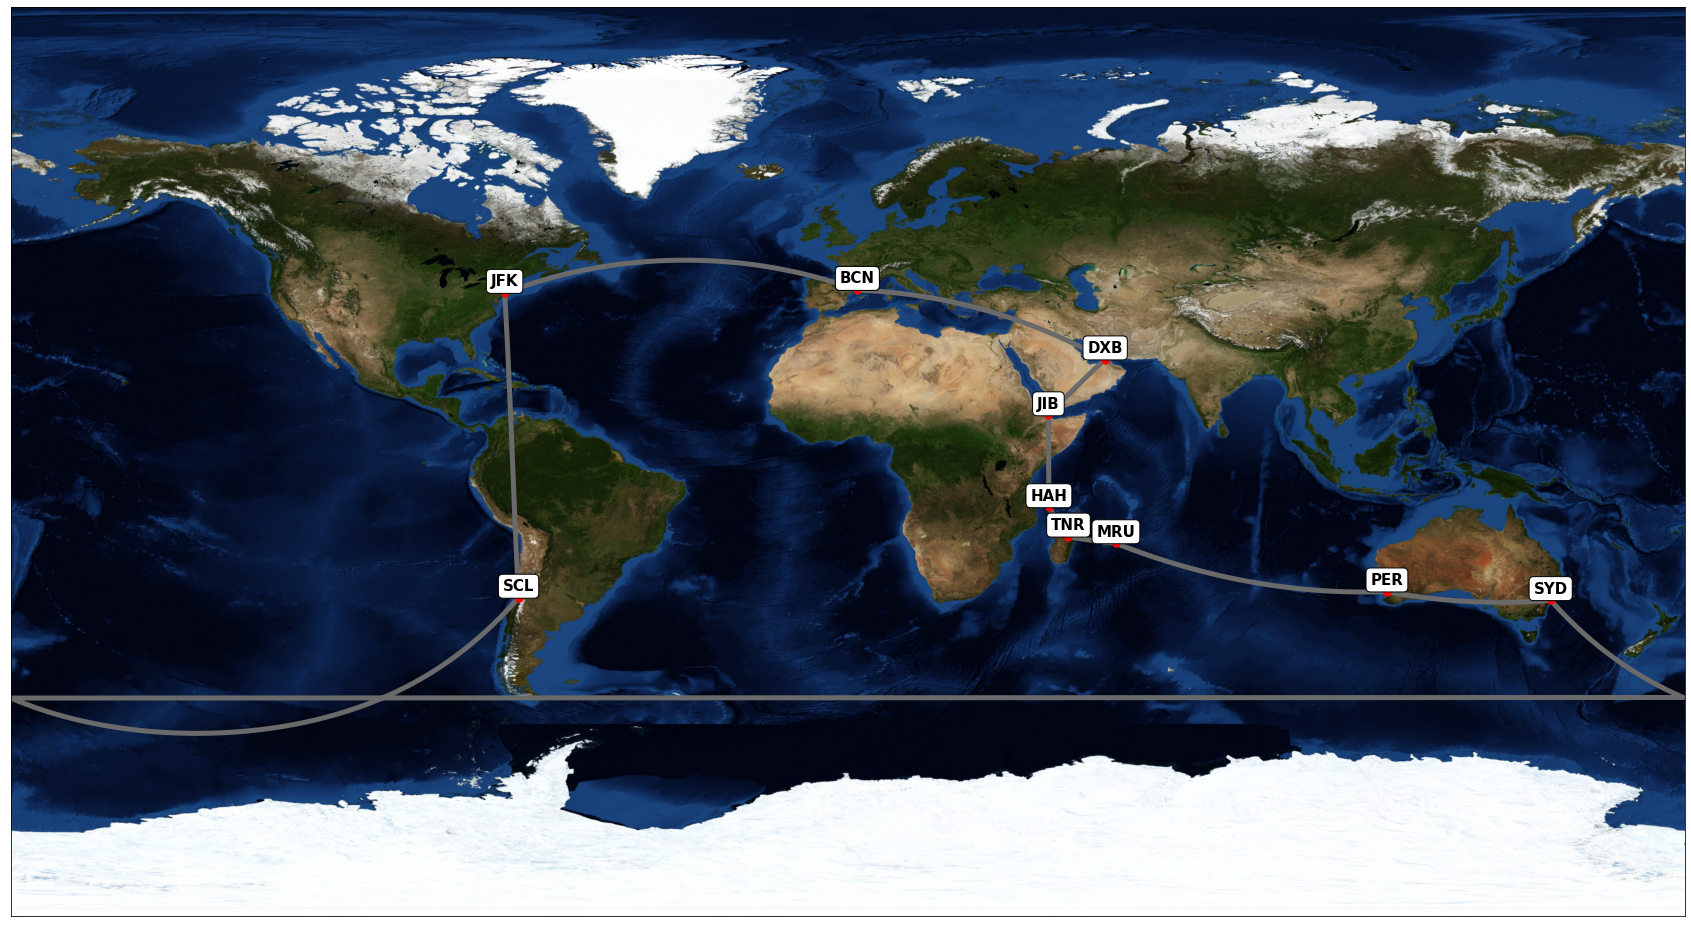

In [8]:
plt.figure(figsize = (30,20))
m = Basemap(projection='gall')
m.warpimage(image='bluemarble')
for s in sites:
    x0, y0 = m(G.nodes[s]['longitude'],G.nodes[s]['latitude'])
    m.scatter(x0,y0,3,marker='o',color='red')
    plt.text(x0,y0+100000,s,fontsize=15,fontweight='bold',ha='center',va='bottom',color="black",bbox=dict(boxstyle="round,pad=0.3", fc="white"))
for sites_pair in sites_pairs:
    route = nx.dijkstra_path(G,source=sites_pair[0],target=sites_pair[1],weight='Distance')
    ss = [(x,y) for x, y in itertools.zip_longest(route, route[1:])]
    ss = ss[:-1]
    for d_site in ss:
        x, y = m.gcpoints(G.nodes[d_site[0]]['longitude'],G.nodes[d_site[0]]['latitude'],
                          G.nodes[d_site[1]]['longitude'],G.nodes[d_site[1]]['latitude'],500)
        m.plot(x, y,color="#6A6A6A",linewidth=5)
        x2, y2 = m([y['longitude'] for x, y in G.nodes(data=True) if x in d_site],
                   [y['latitude'] for x, y in G.nodes(data=True) if x in d_site])
        m.scatter(x2, y2,color='red',s=50,zorder=2)
plt.show()